In [50]:
import geopandas as pd
import contextily as ctx # Used for contextual basemaps
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube # Used for rasterizing
import os
import shapely
import imageio # Used for making animated GIFs
import numpy as np
from IPython.display import Image
from osgeo import gdal # Raster operations
import zipfile
import rasterio
import rasterio.merge
import rasterio.plot
import rasterio.warp
plt.rcParams['figure.figsize'] = (20, 20)
os.listdir("input")

['lds-nz-road-centrelines-topo-150k-FGDB.zip',
 'lds-nz-8m-digital-elevation-model-2012-GTiff-auckland-region.zip',
 'statsnzpopulation-by-meshblock-2013-census-FGDB.zip',
 'statsnz2018-census-electoral-population-meshblock-2020-FGDB.zip',
 'statsnzregional-council-2021-clipped-generalised-FGDB.zip',
 'lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-FGDB.zip']

First, read regional council bounds. This geometry will be used to clip NZ-wide datasets to just the region of interest, Auckland

epsg:2193
CPU times: user 1.64 s, sys: 71.1 ms, total: 1.71 s
Wall time: 15.4 s


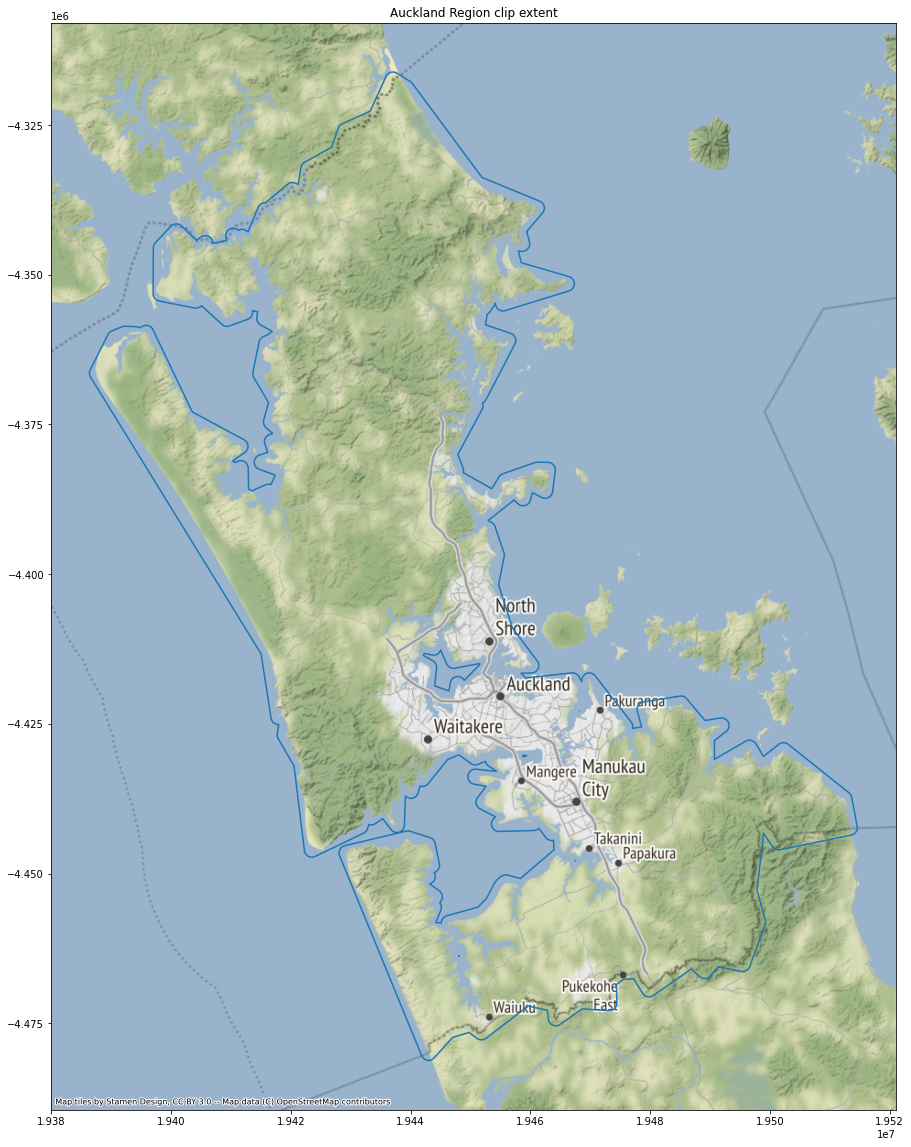

In [2]:
%%time
REGC = pd.read_file("input/statsnzregional-council-2021-clipped-generalised-FGDB.zip!regional-council-2021-clipped-generalised.gdb")
AKL = REGC[REGC.REGC2021_V1_00_NAME == "Auckland Region"].copy()
# Filter out islands
AKL["geometry"] = max(AKL.geometry.explode(), key=lambda a: a.area)
# Coordinate reference system (projection)
print(AKL.crs)
# Simplify geometry to speed up clip operations
AKL = AKL.simplify(1000).buffer(1000)
ax = AKL.to_crs(epsg=3857).boundary.plot()
ax.set_title("Auckland Region clip extent")
ctx.add_basemap(ax)

## Land use
Load the LRIS Land Cover Database (downloaded in GDB format from https://lris.scinfo.org.nz/layer/104400-lcdb-v50-land-cover-database-version-50-mainland-new-zealand/)

In [3]:
%%time
df = pd.read_file("zip://input/lris-lcdb-v50-land-cover-database-version-50-mainland-new-zealand-FGDB.zip!lcdb-v50-land-cover-database-version-50-mainland-new-zealand.gdb")

CPU times: user 1min 29s, sys: 1.95 s, total: 1min 31s
Wall time: 1min 31s


In [4]:
print(df.columns)
print(df.crs)
display(df.sample(5))

Index(['Name_2018', 'Name_2012', 'Name_2008', 'Name_2001', 'Name_1996',
       'Class_2018', 'Class_2012', 'Class_2008', 'Class_2001', 'Class_1996',
       'Wetland_18', 'Wetland_12', 'Wetland_08', 'Wetland_01', 'Wetland_96',
       'Onshore_18', 'Onshore_12', 'Onshore_08', 'Onshore_01', 'Onshore_96',
       'EditAuthor', 'EditDate', 'LCDB_UID', 'geometry'],
      dtype='object')
epsg:2193


Name_2018             Name_2012             Name_2008  \
43586     Forest - Harvested         Exotic Forest         Exotic Forest   
255569  Manuka and/or Kanuka  Manuka and/or Kanuka  Manuka and/or Kanuka   
1006                Mangrove              Mangrove              Mangrove   
246816   Deciduous Hardwoods   Deciduous Hardwoods   Deciduous Hardwoods   
488793        Gravel or Rock        Gravel or Rock        Gravel or Rock   

                   Name_2001             Name_1996  Class_2018  Class_2012  \
43586          Exotic Forest         Exotic Forest          64          71   
255569  Manuka and/or Kanuka  Manuka and/or Kanuka          52          52   
1006                Mangrove              Mangrove          70          70   
246816   Deciduous Hardwoods   Deciduous Hardwoods          68          68   
488793        Gravel or Rock        Gravel or Rock          16          16   

        Class_2008  Class_2001  Class_1996  ... Wetland_96 Onshore_18  \
43586           71          71          71  ...         no        yes   
255569          52          52          52  ...         no        yes   
1006            70          70          70  ...        yes         no   
246816          68          68          68  ...         no        yes   
488793          16          16          16  ...         no        yes   

       Onshore_12 Onshore_08 Onshore_01 Onshore_96         EditAuthor  \
43586         yes        yes        yes        yes  Landcare Research   
255569        yes        yes        yes        yes  Landcare Research   
1006           no         no         no         no  Landcare Research   
246816        yes        yes        yes        yes          Terralink   
488793        yes        yes        yes        yes          Terralink   

                   EditDate        LCDB_UID  \
43586   2019-12-01T00:00:00  lcdb1000205546   
255569  2014-06-30T00:00:00  lcdb1000408038   
1006    2004-06-30T00:00:00  lcdb1000182590   
246816  2004-06-30T00:00:00  lcdb1000135707   
488793  2004-06-30T00:00:00  lcdb1000013134   

                                                 geometry  
43586   MULTIPOLYGON (((1680353.526 5659207.501, 16803...  
255569  MULTIPOLYGON (((1716049.661 5948794.088, 17160...  
1006    MULTIPOLYGON (((1709615.997 6090730.437, 17096...  
246816  MULTIPOLYGON (((1904998.890 5752381.377, 19049...  
488793  MULTIPOLYGON (((1848819.184 5561053.228, 18487...  

[5 rows x 24 columns]

In [5]:
%%time
df = pd.clip(df, AKL)

CPU times: user 50.5 s, sys: 0 ns, total: 50.5 s
Wall time: 50.5 s


In [6]:
df.sample(5)

Name_2018                         Name_2012  \
343122  Broadleaved Indigenous Hardwoods  Broadleaved Indigenous Hardwoods   
303144                     Exotic Forest                     Exotic Forest   
75                  Estuarine Open Water              Estuarine Open Water   
56910    High Producing Exotic Grassland   High Producing Exotic Grassland   
197344                 Indigenous Forest                 Indigenous Forest   

                               Name_2008                         Name_2001  \
343122  Broadleaved Indigenous Hardwoods  Broadleaved Indigenous Hardwoods   
303144                     Exotic Forest                     Exotic Forest   
75                  Estuarine Open Water              Estuarine Open Water   
56910                      Exotic Forest                     Exotic Forest   
197344                 Indigenous Forest                 Indigenous Forest   

                               Name_1996  Class_2018  Class_2012  Class_2008  \
343122  Broadleaved Indigenous Hardwoods          54          54          54   
303144                     Exotic Forest          71          71          71   
75                  Estuarine Open Water          22          22          22   
56910                      Exotic Forest          40          40          71   
197344                 Indigenous Forest          69          69          69   

        Class_2001  Class_1996  ... Wetland_96 Onshore_18 Onshore_12  \
343122          54          54  ...         no        yes        yes   
303144          71          71  ...         no        yes        yes   
75              22          22  ...         no         no         no   
56910           71          71  ...         no        yes        yes   
197344          69          69  ...         no        yes        yes   

       Onshore_08 Onshore_01 Onshore_96         EditAuthor  \
343122        yes        yes        yes  Landcare Research   
303144        yes        yes        yes          Terralink   
75             no         no         no          Terralink   
56910         yes        yes        yes  Landcare Research   
197344        yes        yes        yes          Terralink   

                   EditDate        LCDB_UID  \
343122  2014-06-30T00:00:00  lcdb1000126187   
303144  2004-06-30T00:00:00  lcdb1000219890   
75      2004-06-30T00:00:00  lcdb1000021441   
56910   2014-06-30T00:00:00  lcdb1000217091   
197344  2004-06-30T00:00:00  lcdb1000165144   

                                                 geometry  
343122  POLYGON ((1755701.121 5877226.771, 1755705.314...  
303144  POLYGON ((1753295.958 5959612.004, 1753258.777...  
75      POLYGON ((1747445.781 5924464.586, 1747303.397...  
56910   POLYGON ((1751065.383 5877732.261, 1751057.778...  
197344  POLYGON ((1753703.470 5918739.734, 1753701.481...  

[5 rows x 24 columns]

In [7]:
df.Name_2018.value_counts()

Exotic Forest                                3981
Indigenous Forest                            3673
Manuka and/or Kanuka                         2282
Broadleaved Indigenous Hardwoods             1788
Built-up Area (settlement)                   1350
High Producing Exotic Grassland              1326
Mangrove                                     1151
Urban Parkland/Open Space                    1099
Estuarine Open Water                          441
Orchard, Vineyard or Other Perennial Crop     436
Short-rotation Cropland                       362
Lake or Pond                                  326
Herbaceous Saline Vegetation                  303
Low Producing Grassland                       291
Gorse and/or Broom                            287
Forest - Harvested                            266
Sand or Gravel                                252
Deciduous Hardwoods                           201
Surface Mine or Dump                          132
Mixed Exotic Shrubland                        120


These classes are far too detailed - simplify to just Urban, Vegetation, Water, Other

In [8]:
def simplify_classes(code):
    if code in [1, 2, 5]:
        return 1, "Urban"
    elif code in [68,69,71]:
        return 2, "Vegetation"
    elif code in [0,20,21,22,45,46]:
        return 3, "Water"
    else:
        return 4, "Other"

summary = []
years = [1996, 2001, 2008, 2012, 2018]
for year in years:
    print(year)
    class_year = f"Class_{year}"
    df[class_year + "_simplified_code"] = df[class_year].apply(lambda c: simplify_classes(c)[0])
    df[class_year + "_simplified_name"] = df[class_year].apply(lambda c: simplify_classes(c)[1])
    summary.append(df[class_year + "_simplified_name"].value_counts())

1996
2001
2008
2012
2018


<AxesSubplot:>

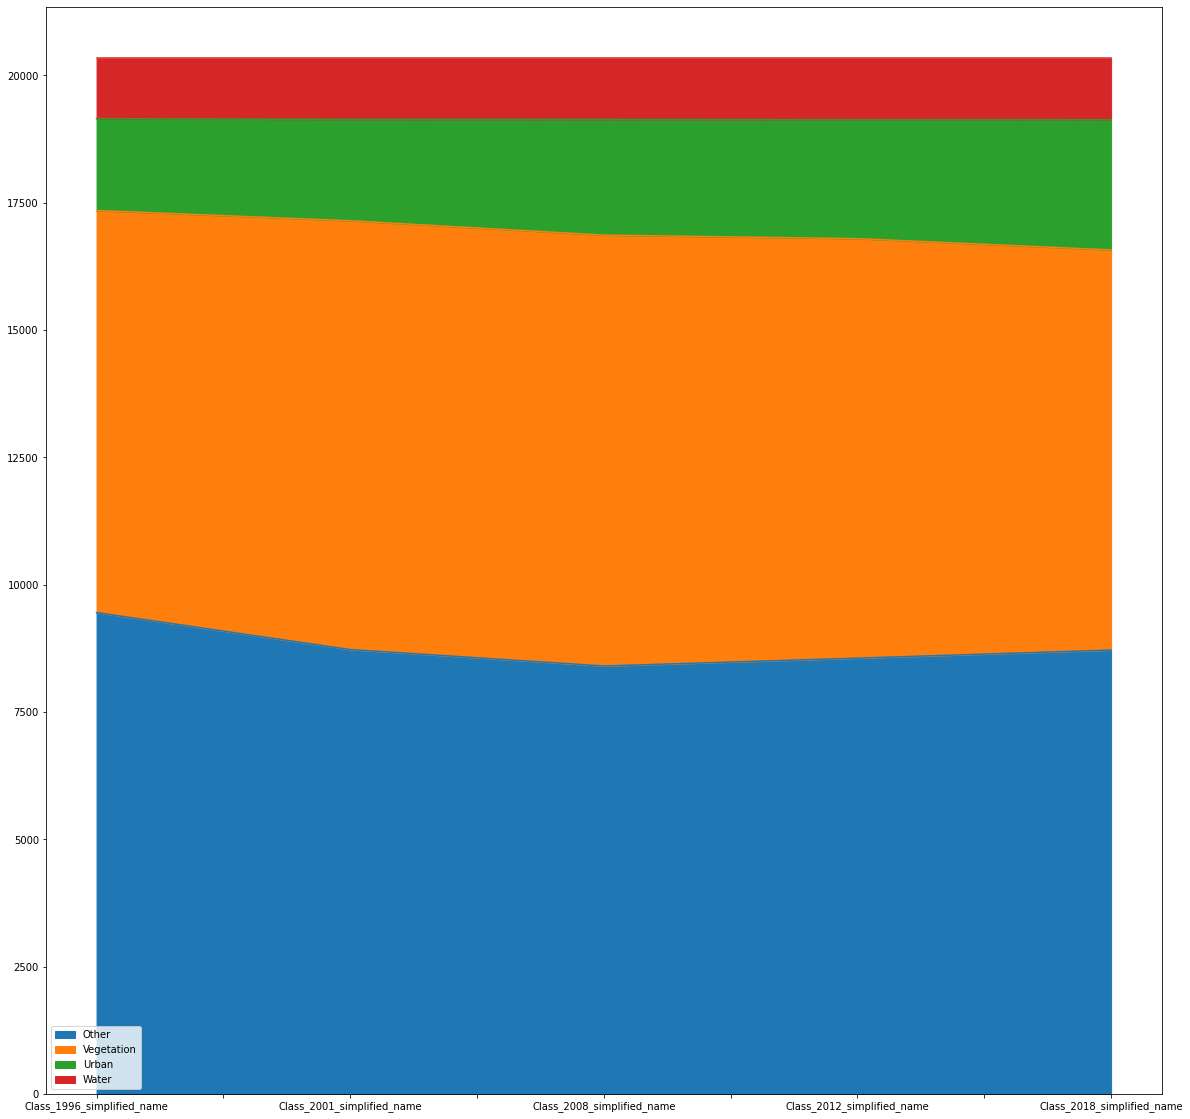

In [9]:
pd.GeoDataFrame(summary).plot.area()

In [10]:
%%capture
# %%capture suppresses output
if not os.path.isfile("land_use.gif"):
    ims = []
    years = [1996, 2001, 2008, 2012, 2018]
    for year in years:
        ax = df.plot(column=f'Class_{year}_simplified_name', legend=True)
        ax.set_title(year)
        ax.figure.tight_layout()
        canvas = ax.figure.canvas
        canvas.draw() # draw the canvas, cache the renderer
        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(canvas.get_width_height()[::-1] + (3,))
        ims.append(image)
    imageio.mimsave("land_use.gif", ims, fps=1)

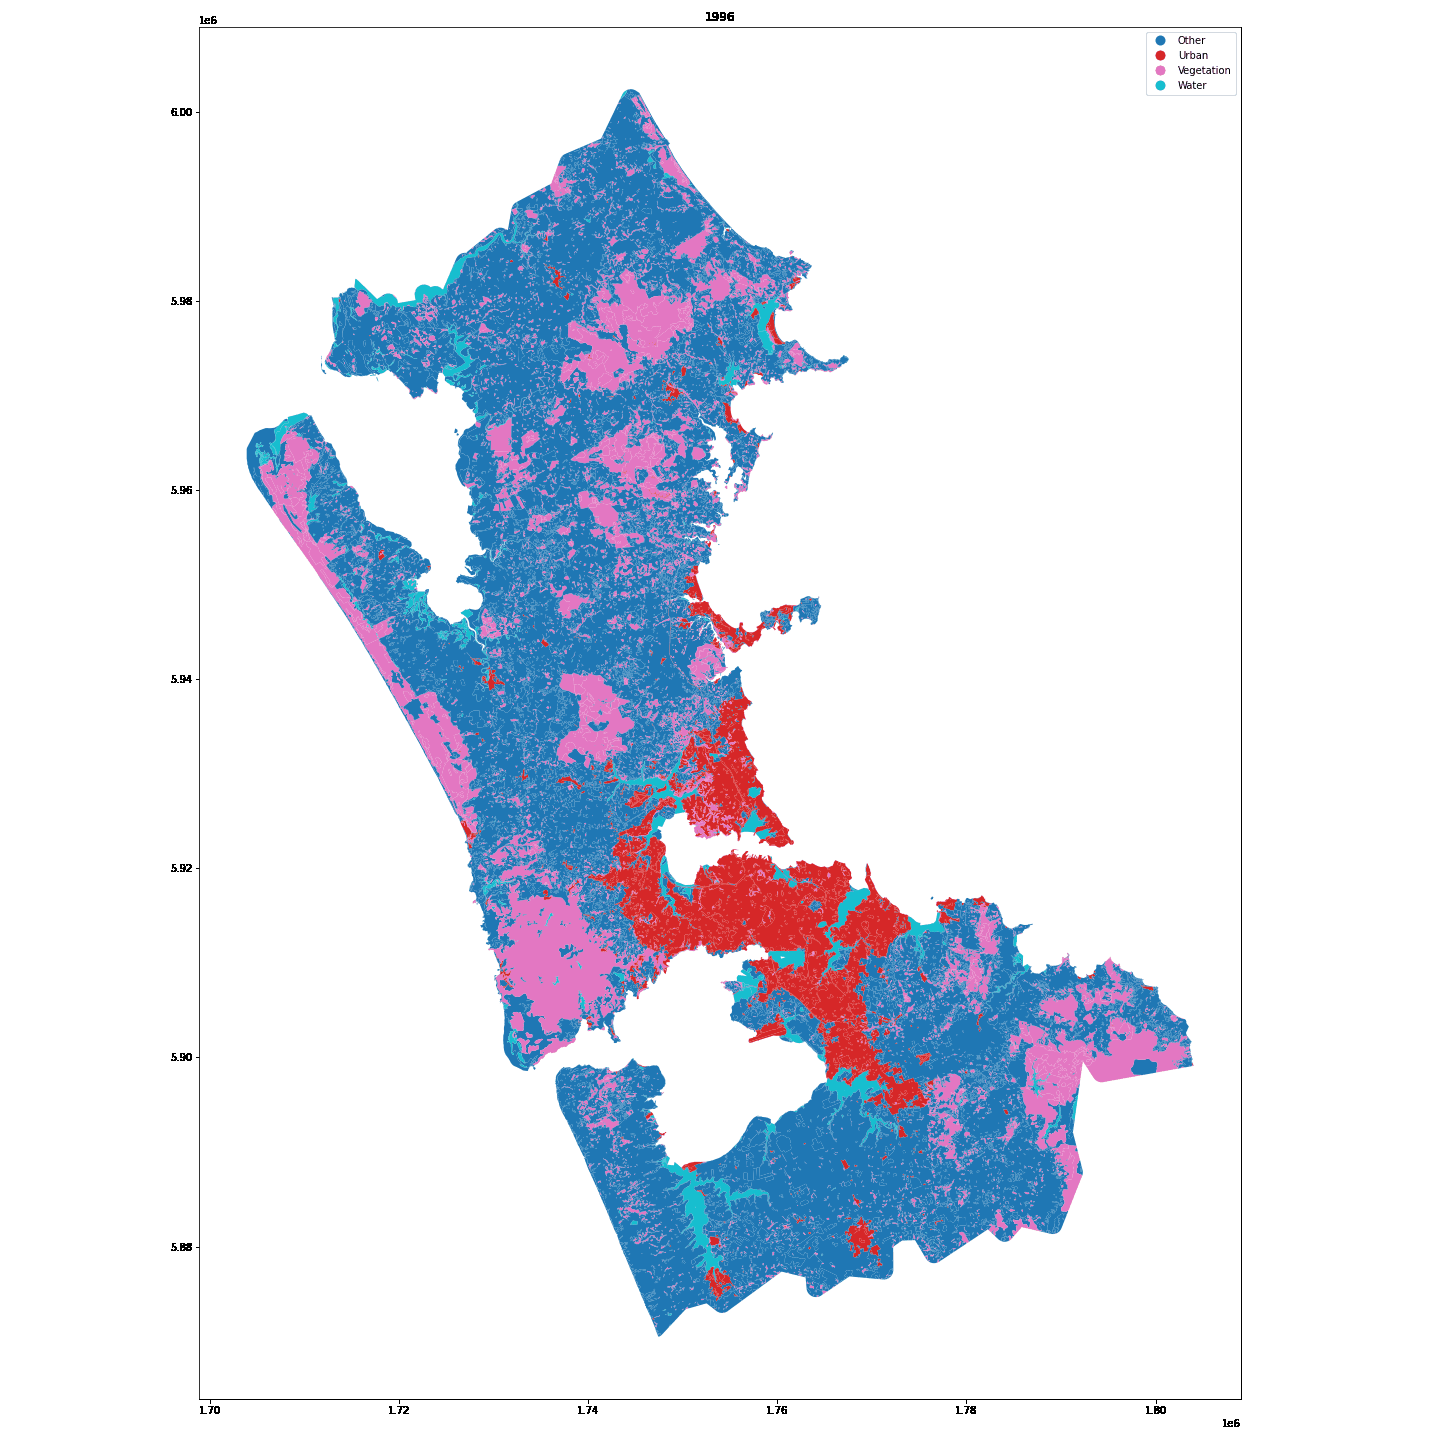

In [11]:
with open('land_use.gif','rb') as file:
    display(Image(file.read()))

In [12]:
cols = [f"Class_{year}_simplified_code" for year in years]
cols

['Class_1996_simplified_code',
 'Class_2001_simplified_code',
 'Class_2008_simplified_code',
 'Class_2012_simplified_code',
 'Class_2018_simplified_code']

In [13]:
%%time
geocube = make_geocube(
    vector_data=df,
    output_crs="epsg:2193",
    measurements=cols,
    resolution=(-100, 100),
    fill=0, # NaNs, like offshore areas, will be 0
)
geocube

CPU times: user 18 s, sys: 371 µs, total: 18 s
Wall time: 18 s


<xarray.Dataset>
Dimensions:                     (x: 1001, y: 1320)
Coordinates:
  * y                           (y) float64 6.002e+06 6.002e+06 ... 5.87e+06
  * x                           (x) float64 1.704e+06 1.704e+06 ... 1.804e+06
    spatial_ref                 int64 0
Data variables:
    Class_1996_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2001_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2008_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2012_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Class_2018_simplified_code  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

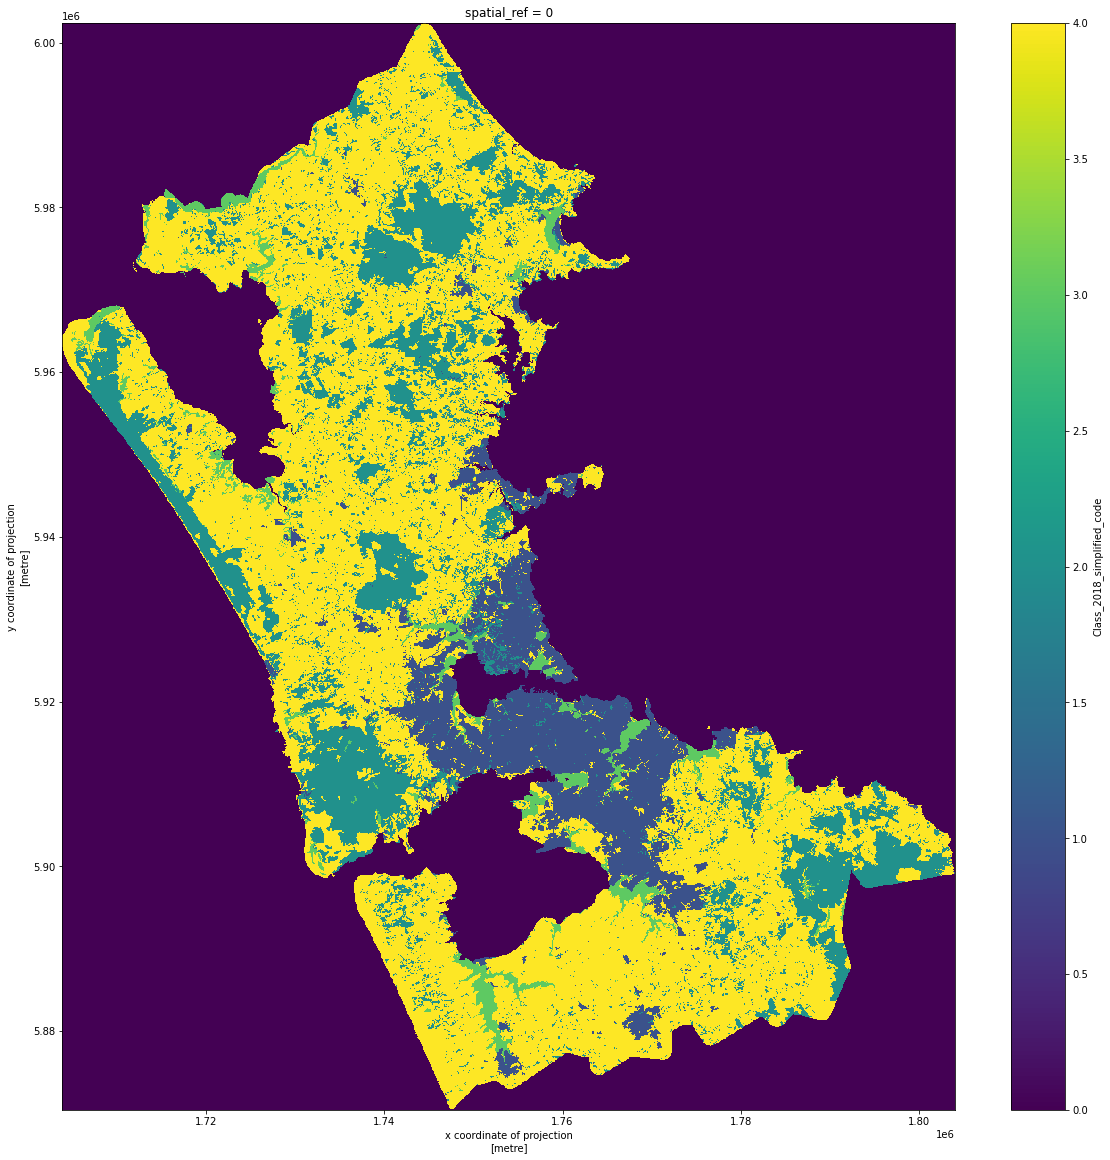

In [14]:
geocube.Class_2018_simplified_code.plot()

In [15]:
for year in years:
    print(year)
    outfile = f"output/land_use_{year}.tif"
    if not os.path.isfile(outfile):
        geocube[f"Class_{year}_simplified_code"].rio.to_raster(outfile, dtype=np.byte) # Use np.byte for smaller output filesize

1996
2001
2008
2012
2018


## Population density

In [16]:
%%time
pop2013 = pd.read_file("input/statsnzpopulation-by-meshblock-2013-census-FGDB.zip!population-by-meshblock-2013-census.gdb")

CPU times: user 8.48 s, sys: 20.1 ms, total: 8.5 s
Wall time: 8.5 s


In [17]:
%%time
pop2013 = pd.clip(pop2013, AKL)

CPU times: user 20.4 s, sys: 0 ns, total: 20.4 s
Wall time: 20.4 s


In [18]:
display(pop2013.sample(5))

Meshblock MeshblockNumber  Population_Count_Usual_Resident_2013  \
19819  MB 0776600         0776600                                   117   
1595   MB 0315700         0315700                                   120   
14908  MB 0432800         0432800                                     6   
15663  MB 0494902         0494902                                    36   
2373   MB 0774215         0774215                                    36   

       Population_Count_Census_Night_2013  \
19819                                 117   
1595                                  120   
14908                                 144   
15663                                 402   
2373                                   39   

                                                geometry  
19819  POLYGON ((1767386.316 5900301.508, 1767334.793...  
1595   POLYGON ((1757987.976 5924104.905, 1757984.840...  
14908  POLYGON ((1757399.865 5920942.269, 1757320.710...  
15663  POLYGON ((1760593.299 5916201.327, 1760625.004...  
2373   POLYGON ((1766433.591 5899681.072, 1766428.192...

In [19]:
#pop2013.Population_Count_Usual_Resident_2013.replace(0, np.nan, inplace=True)

<AxesSubplot:ylabel='Frequency'>

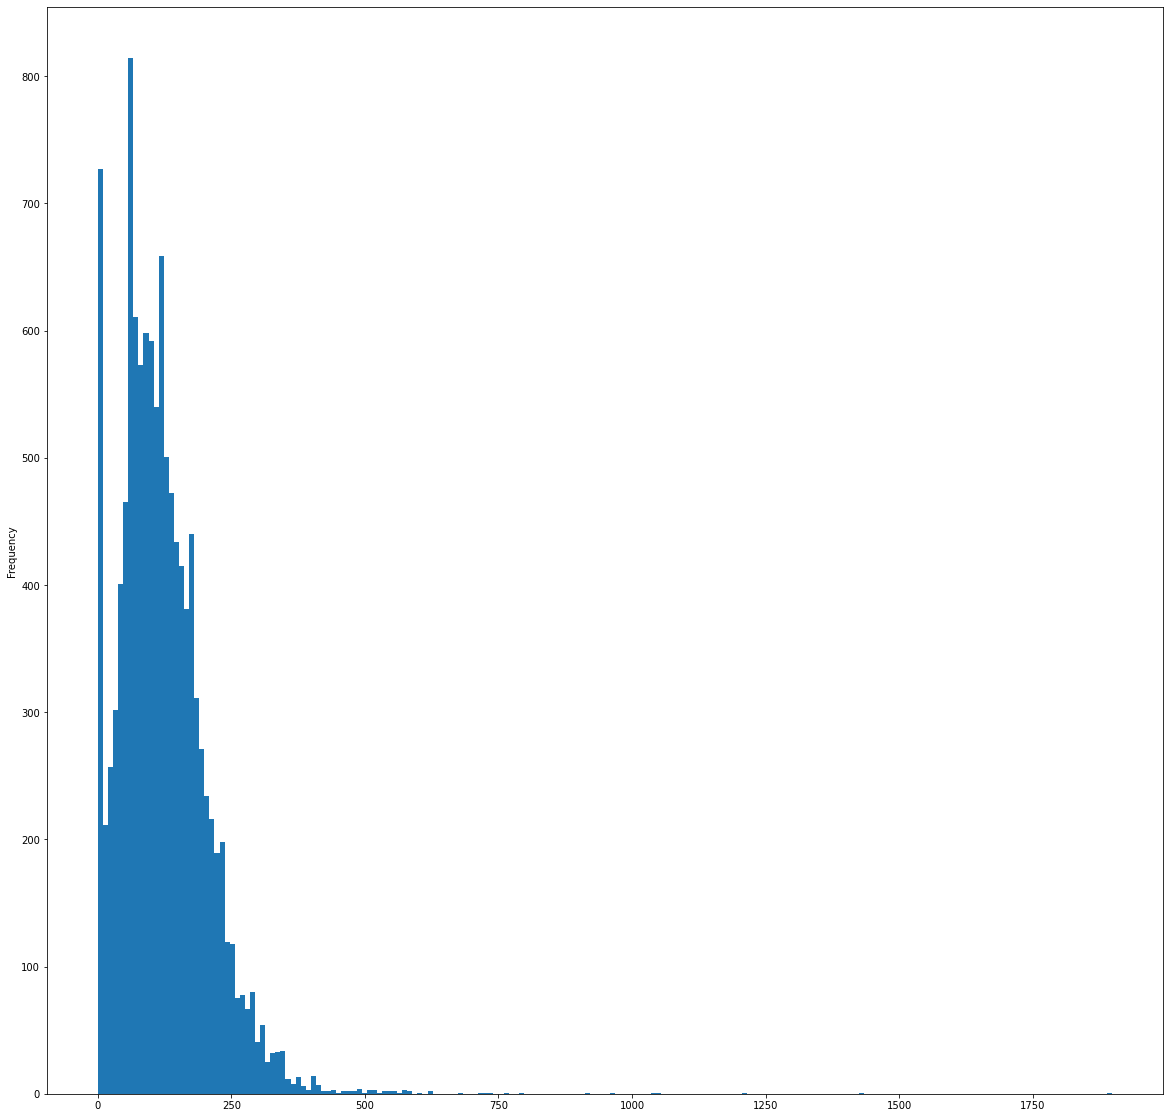

In [20]:
pop2013.Population_Count_Usual_Resident_2013.plot(kind="hist", bins=200)

In [21]:
%%time
pop2013_cube = make_geocube(
    vector_data=pop2013,
    measurements=["Population_Count_Usual_Resident_2013"],
    like=geocube, # Ensures dimensions match
    fill=0 # NaNs, like offshore areas, will be 0
)
pop2013_cube

CPU times: user 2.63 s, sys: 73 µs, total: 2.63 s
Wall time: 2.63 s


<xarray.Dataset>
Dimensions:                               (x: 1001, y: 1320)
Coordinates:
  * y                                     (y) float64 6.002e+06 ... 5.87e+06
  * x                                     (x) float64 1.704e+06 ... 1.804e+06
    spatial_ref                           int64 0
Data variables:
    Population_Count_Usual_Resident_2013  (y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

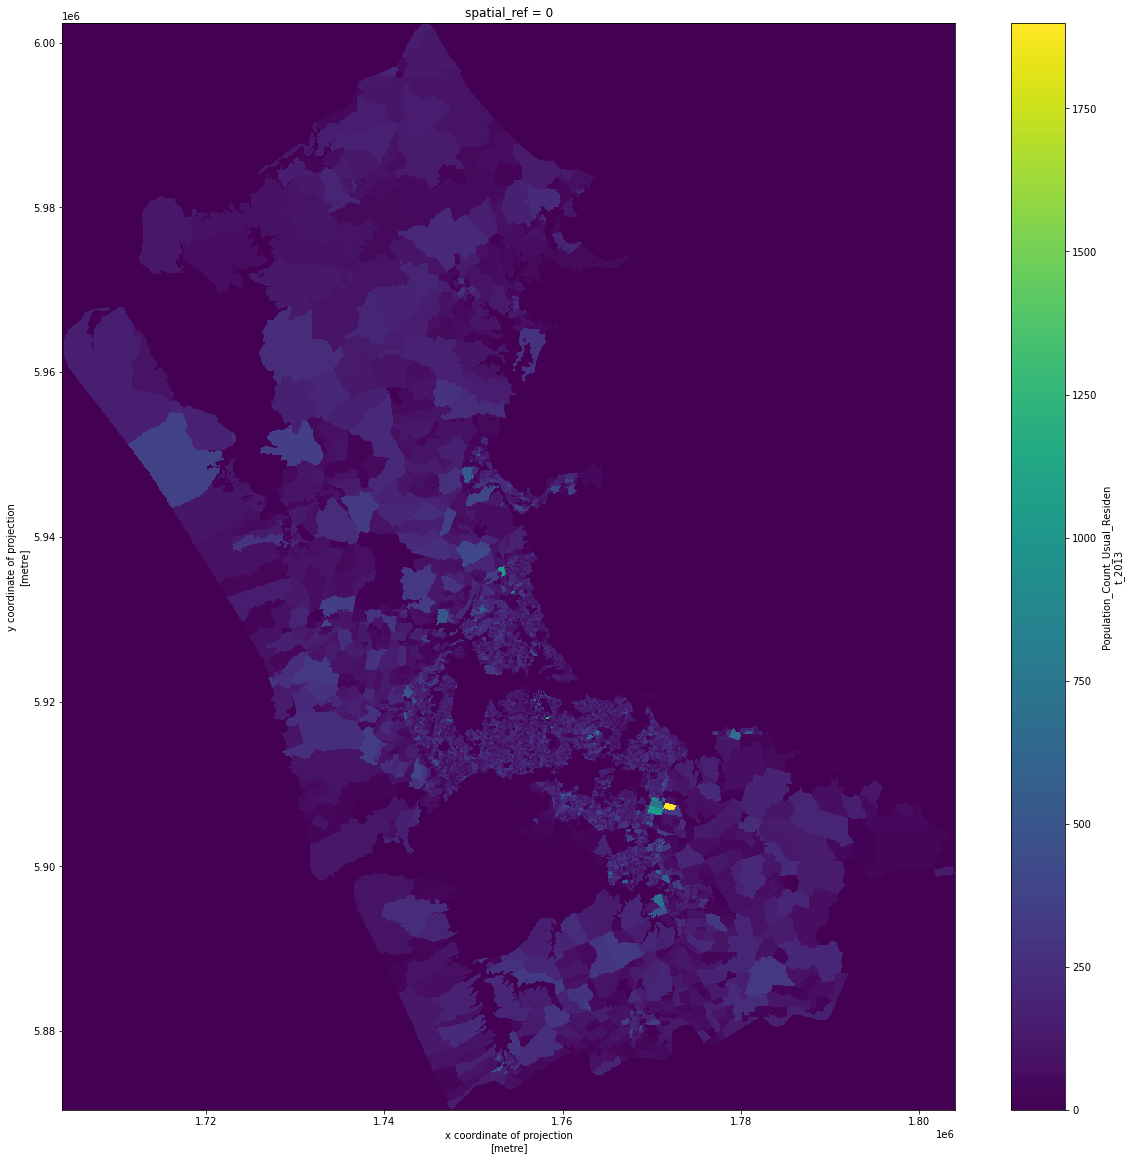

In [22]:
pop2013_cube.Population_Count_Usual_Resident_2013.plot()
outfile = "output/pop2013.tif"
if not os.path.isfile(outfile):
    # byte max value is 255, and we have larger values than that here. uint16 max value is 65535, which is fine
    pop2013_cube.Population_Count_Usual_Resident_2013.rio.to_raster(outfile, dtype=np.uint16)

In [23]:
%%time
pop2018 = pd.read_file("input/statsnz2018-census-electoral-population-meshblock-2020-FGDB.zip!2018-census-electoral-population-meshblock-2020.gdb")

CPU times: user 9.27 s, sys: 30.1 ms, total: 9.3 s
Wall time: 9.3 s


In [24]:
%%time
pop2018 = pd.clip(pop2018, AKL)

CPU times: user 23.3 s, sys: 0 ns, total: 23.3 s
Wall time: 23.3 s


In [25]:
display(pop2018.sample(5))

MB2020_V2_00  General_Electoral_Population  Maori_Electoral_Population  \
15817      0489500                           129                        -999   
46415      4003421                          -999                        -999   
44110      4000741                           117                           9   
12953      0214900                           132                           6   
12835      0207501                           213                           6   

      GED2020_V1_00    GED2020_V1_00_NAME GED2020_V1_00_NAME_ASCII  \
15817           011                 Epsom                    Epsom   
46415           053              Te Atatū                 Te Atatu   
44110           039          Port Waikato             Port Waikato   
12953           018  Kaipara ki Mahurangi     Kaipara ki Mahurangi   
12835           031             Northcote                Northcote   

      MED2020_V1_00 MED2020_V1_00_NAME MED2020_V1_00_NAME_ASCII  \
15817             3    Tāmaki Makaurau          Tamaki Makaurau   
46415             3    Tāmaki Makaurau          Tamaki Makaurau   
44110             1    Hauraki-Waikato          Hauraki-Waikato   
12953             5     Te Tai Tokerau           Te Tai Tokerau   
12835             5     Te Tai Tokerau           Te Tai Tokerau   

       LAND_AREA_SQ_KM  AREA_SQ_KM  Shape_Length  \
15817         0.042862    0.042862    884.456557   
46415         0.049981    0.049981    900.585963   
44110         0.076046    0.076046   1292.431271   
12953         1.256513    1.256513   4920.366345   
12835         0.046583    0.046583    950.944089   

                                                geometry  
15817  POLYGON ((1760958.242 5917231.202, 1760938.339...  
46415  POLYGON ((1747717.983 5917876.155, 1747718.286...  
44110  POLYGON ((1769975.346 5880804.397, 1769831.504...  
12953  POLYGON ((1737313.637 5929363.076, 1737358.936...  
12835  POLYGON ((1754703.230 5926036.690, 1754708.978...

In [26]:
pop2018.General_Electoral_Population.replace(-999, 0, inplace=True)

<AxesSubplot:ylabel='Frequency'>

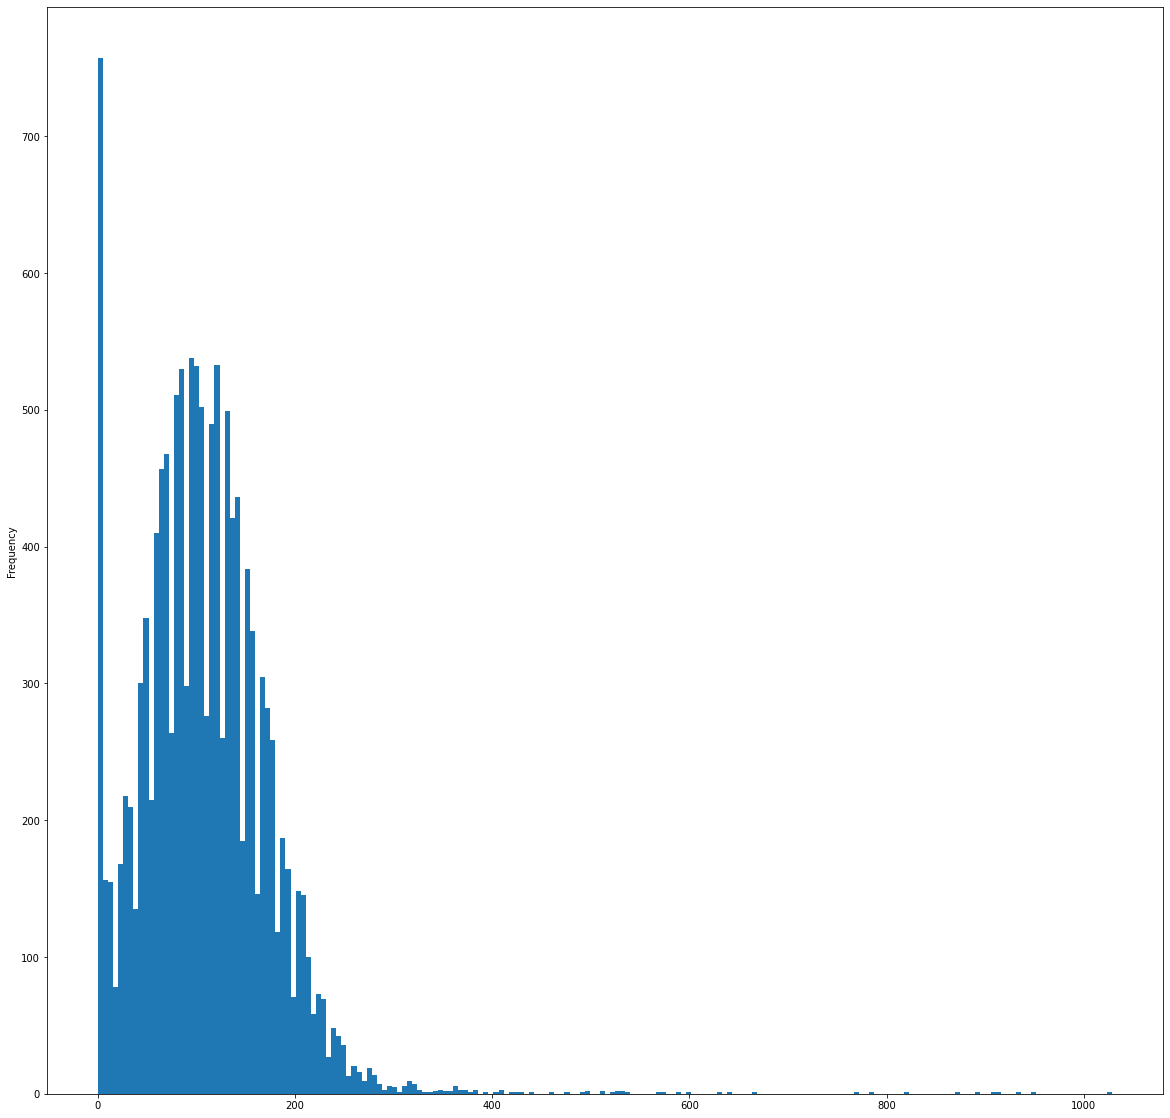

In [27]:
pop2018.General_Electoral_Population.plot(kind="hist", bins=200)

In [28]:
%%time
pop2018_cube = make_geocube(
    vector_data=pop2018,
    measurements=["General_Electoral_Population"],
    like=geocube, # Ensures dimensions match
    fill=0
)
pop2018_cube

CPU times: user 2.47 s, sys: 123 µs, total: 2.47 s
Wall time: 2.46 s


<xarray.Dataset>
Dimensions:                       (x: 1001, y: 1320)
Coordinates:
  * y                             (y) float64 6.002e+06 6.002e+06 ... 5.87e+06
  * x                             (x) float64 1.704e+06 1.704e+06 ... 1.804e+06
    spatial_ref                   int64 0
Data variables:
    General_Electoral_Population  (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

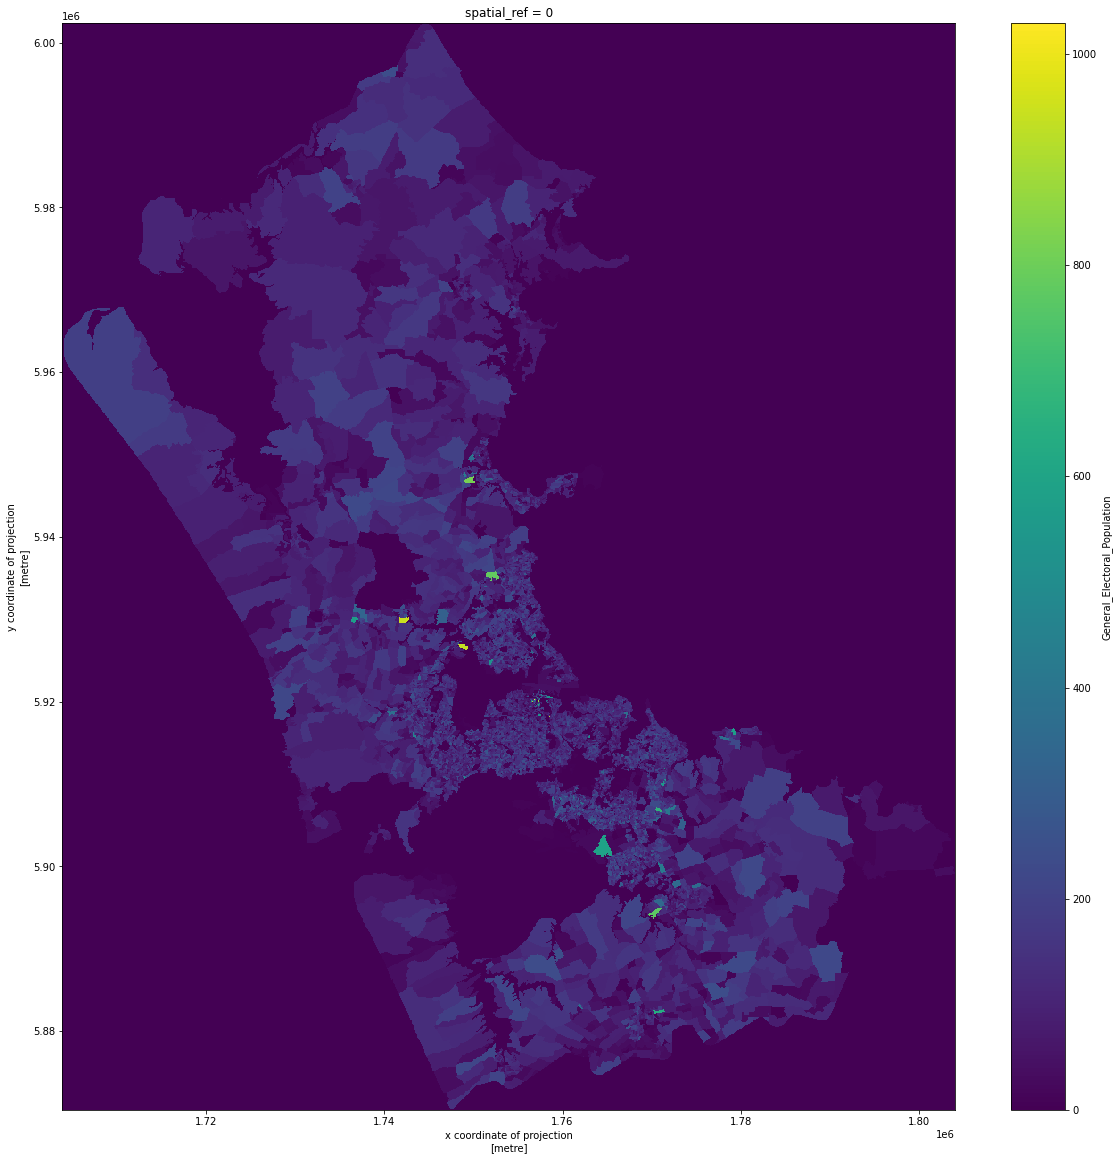

In [29]:
pop2018_cube.General_Electoral_Population.plot()
outfile = "output/pop2018.tif"
if not os.path.isfile(outfile):
    pop2018_cube.General_Electoral_Population.rio.to_raster(outfile, dtype=np.uint16)

## Distance from major roads

In [30]:
%%time
roads = pd.read_file("input/lds-nz-road-centrelines-topo-150k-FGDB.zip!nz-road-centrelines-topo-150k.gdb")

CPU times: user 8.81 s, sys: 10.3 ms, total: 8.82 s
Wall time: 8.82 s


In [31]:
%%time
akl_roads = pd.clip(roads, AKL)

CPU times: user 25.5 s, sys: 9.86 ms, total: 25.5 s
Wall time: 25.5 s


In [32]:
# If a road has a highway number (hway_num not None), it's a highway/motorway
mway = akl_roads[~akl_roads.hway_num.isna()].copy()
mway

t50_fid                  name_ascii macronated  \
512     100120610       KAIPARA COAST HIGHWAY          N   
2933      3198057             STATE HIGHWAY 1          N   
2934      3198059             STATE HIGHWAY 1          N   
3320      3200754                PAERATA ROAD          N   
3324      3200792      UPPER HARBOUR MOTORWAY          N   
...           ...                         ...        ...   
138240  100048291   AUCKLAND-WAIWERA MOTORWAY          N   
138301  100048432  AUCKLAND-HAMILTON MOTORWAY          N   
138337  100048532             STATE HIGHWAY 1          N   
138369  100048589            PORT ALBERT ROAD          N   
138680  100118365      SOUTH-WESTERN MOTORWAY          N   

                              name hway_num  rna_sufi  lane_count way_count  \
512          KAIPARA COAST HIGHWAY       16   3007739           2      None   
2933               STATE HIGHWAY 1        1   3027695           2      None   
2934               STATE HIGHWAY 1        1   3027695           2      None   
3320                  PAERATA ROAD       22   3000260           2      None   
3324        UPPER HARBOUR MOTORWAY       18   3047073           4      None   
...                            ...      ...       ...         ...       ...   
138240   AUCKLAND-WAIWERA MOTORWAY        1   3067966           7      None   
138301  AUCKLAND-HAMILTON MOTORWAY        1   3017109           1      None   
138337             STATE HIGHWAY 1        1   3027695           4      None   
138369            PORT ALBERT ROAD       16   3013274           2      None   
138680      SOUTH-WESTERN MOTORWAY       20   3018532           4      None   

       status surface                                           geometry  
512      None  sealed  LINESTRING (1732000.000 5944172.070, 1732048.5...  
2933     None  sealed  LINESTRING (1748581.508 5968975.145, 1748558.4...  
2934     None  sealed  LINESTRING (1748171.047 5971284.152, 1748129.9...  
3320     None  sealed  LINESTRING (1767236.112 5888088.508, 1767244.3...  
3324     None  sealed  LINESTRING (1747954.314 5927269.837, 1747970.0...  
...       ...     ...                                                ...  
138240   None  sealed  LINESTRING (1755881.018 5922863.734, 1755886.4...  
138301   None  sealed  LINESTRING (1765115.647 5909916.697, 1765092.7...  
138337   None  sealed  LINESTRING (1748892.089 5949596.727, 1748892.0...  
138369   None  sealed  LINESTRING (1734173.019 5980575.187, 1734175.6...  
138680   None  sealed  LINESTRING (1760066.252 5908184.133, 1760043.9...  

[426 rows x 11 columns]

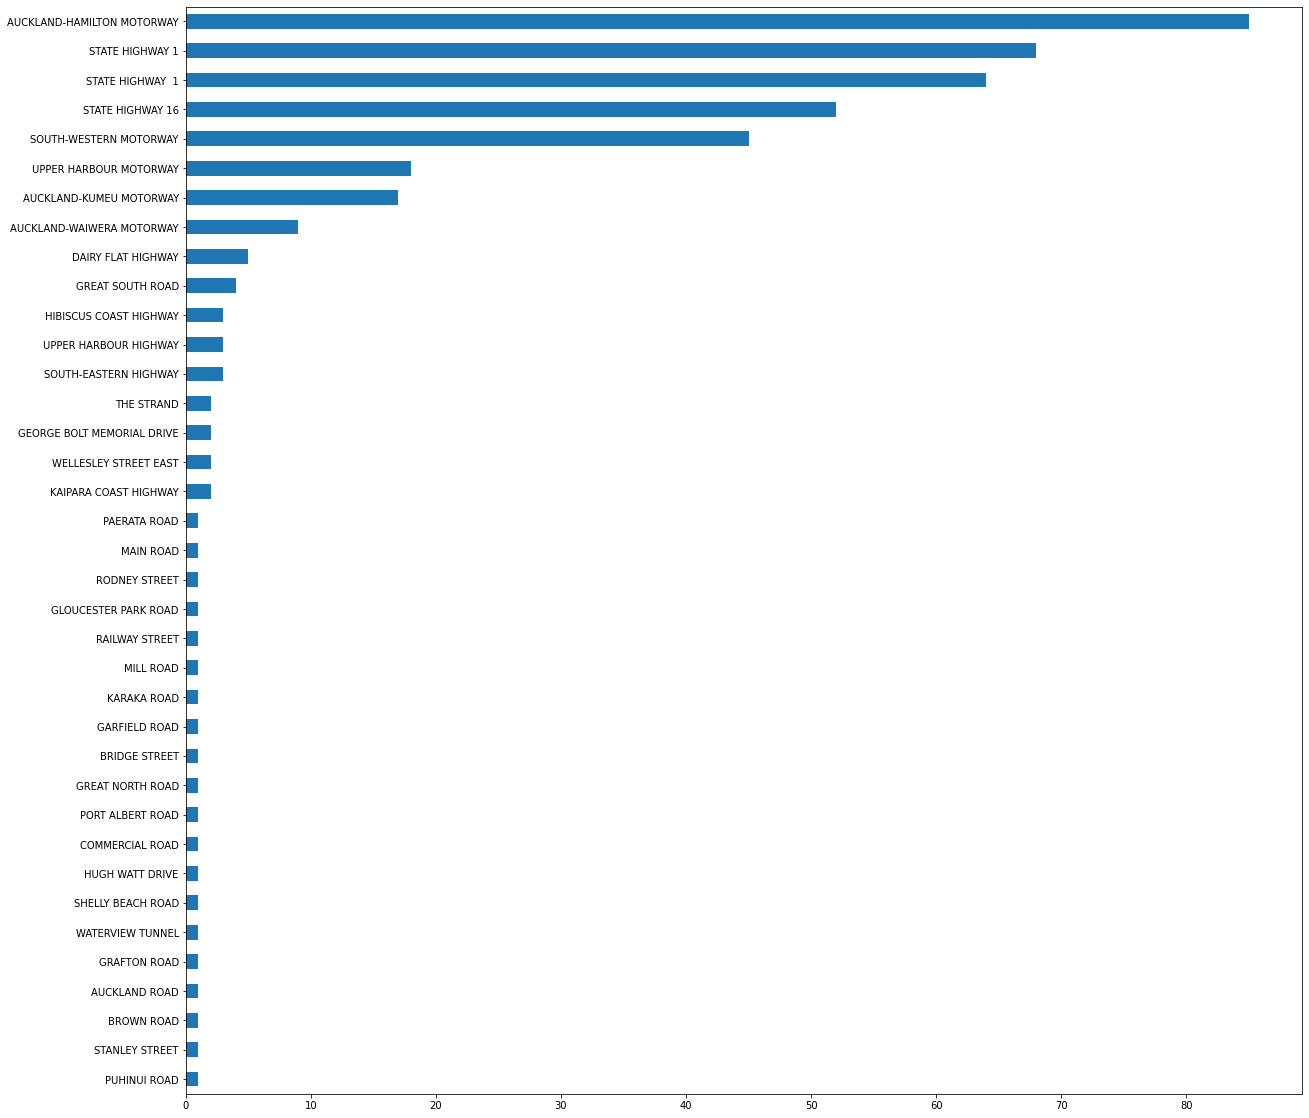

In [33]:
mway.name.value_counts().head(50).plot(kind="barh").invert_yaxis()

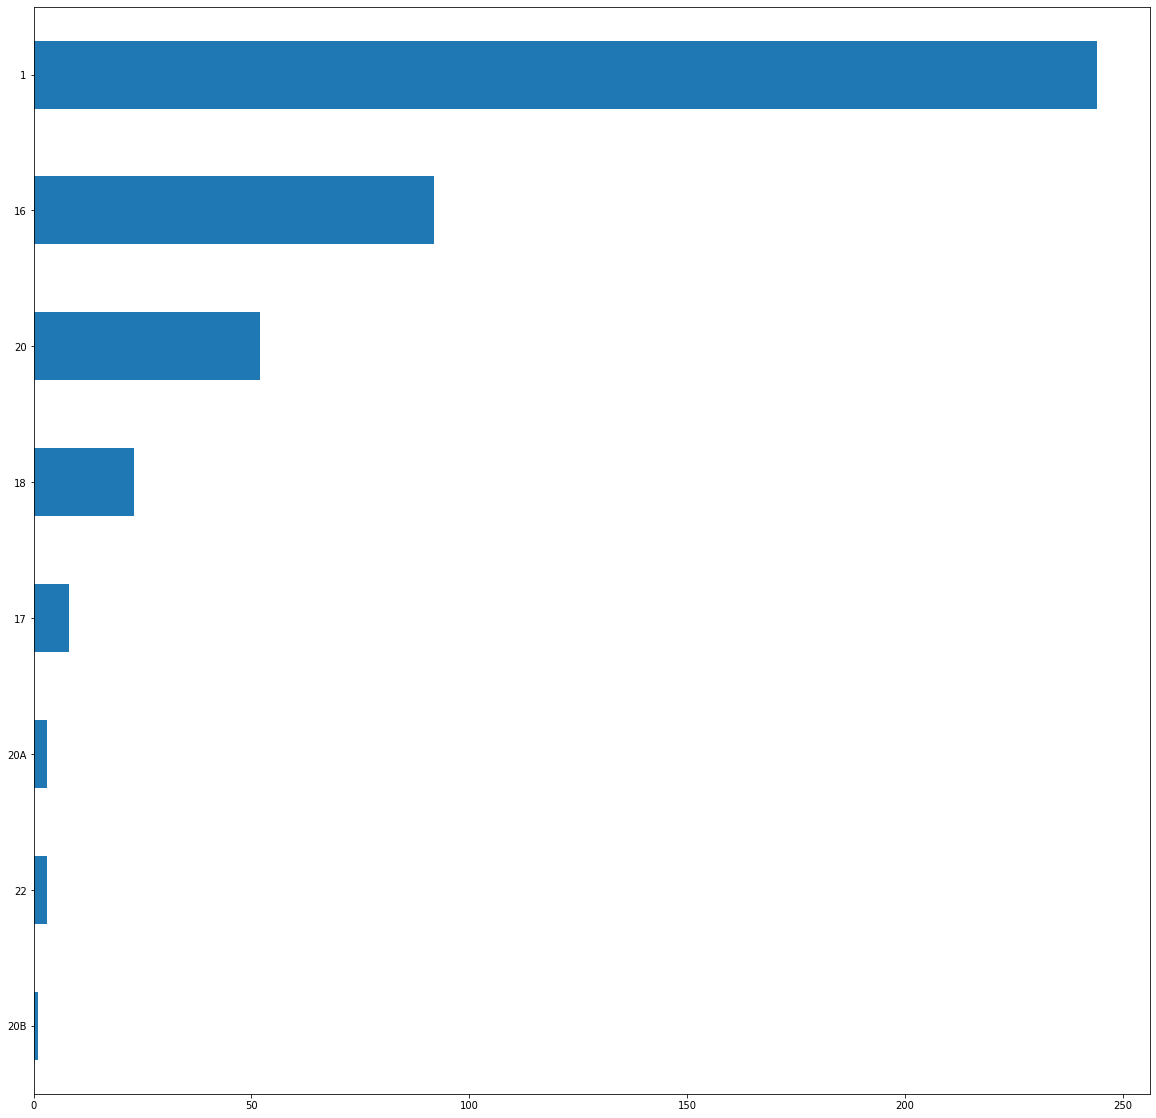

In [34]:
mway.hway_num.value_counts().head(50).plot(kind="barh").invert_yaxis()

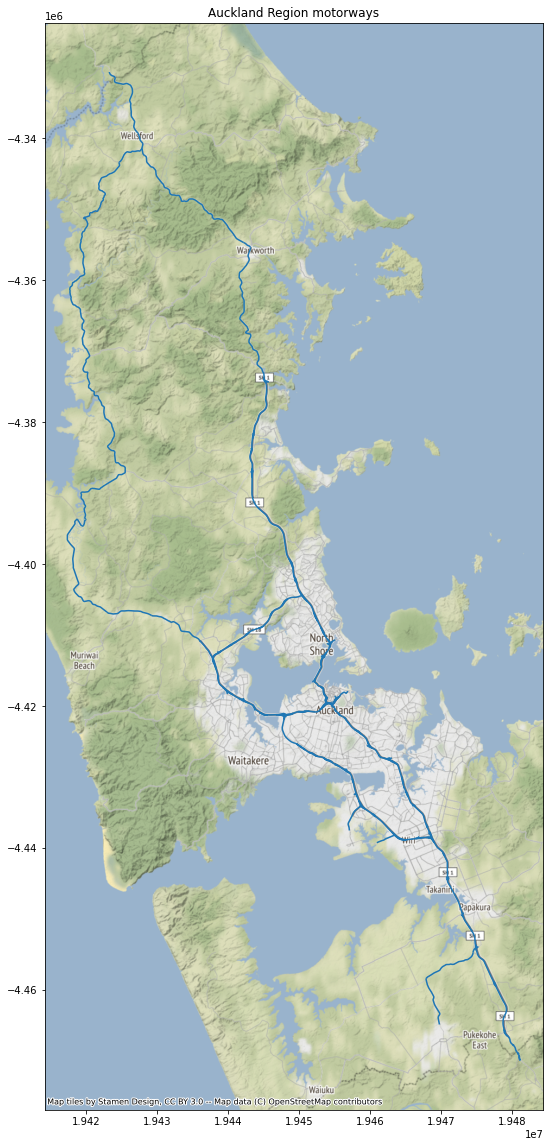

In [35]:
ax = mway.to_crs(epsg=3857).plot()
ax.set_title("Auckland Region motorways")
ctx.add_basemap(ax)

In [36]:
%%time
mway_cube = make_geocube(
    vector_data=mway,
    measurements=["lane_count"],
    like=geocube, # Ensures dimensions match
    fill=0, # 0 works fine here, as every mway has at least one lane
)
mway_cube

CPU times: user 263 ms, sys: 72 µs, total: 263 ms
Wall time: 261 ms


<xarray.Dataset>
Dimensions:      (x: 1001, y: 1320)
Coordinates:
  * y            (y) float64 6.002e+06 6.002e+06 ... 5.871e+06 5.87e+06
  * x            (x) float64 1.704e+06 1.704e+06 ... 1.804e+06 1.804e+06
    spatial_ref  int64 0
Data variables:
    lane_count   (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    grid_mapping:  spatial_ref

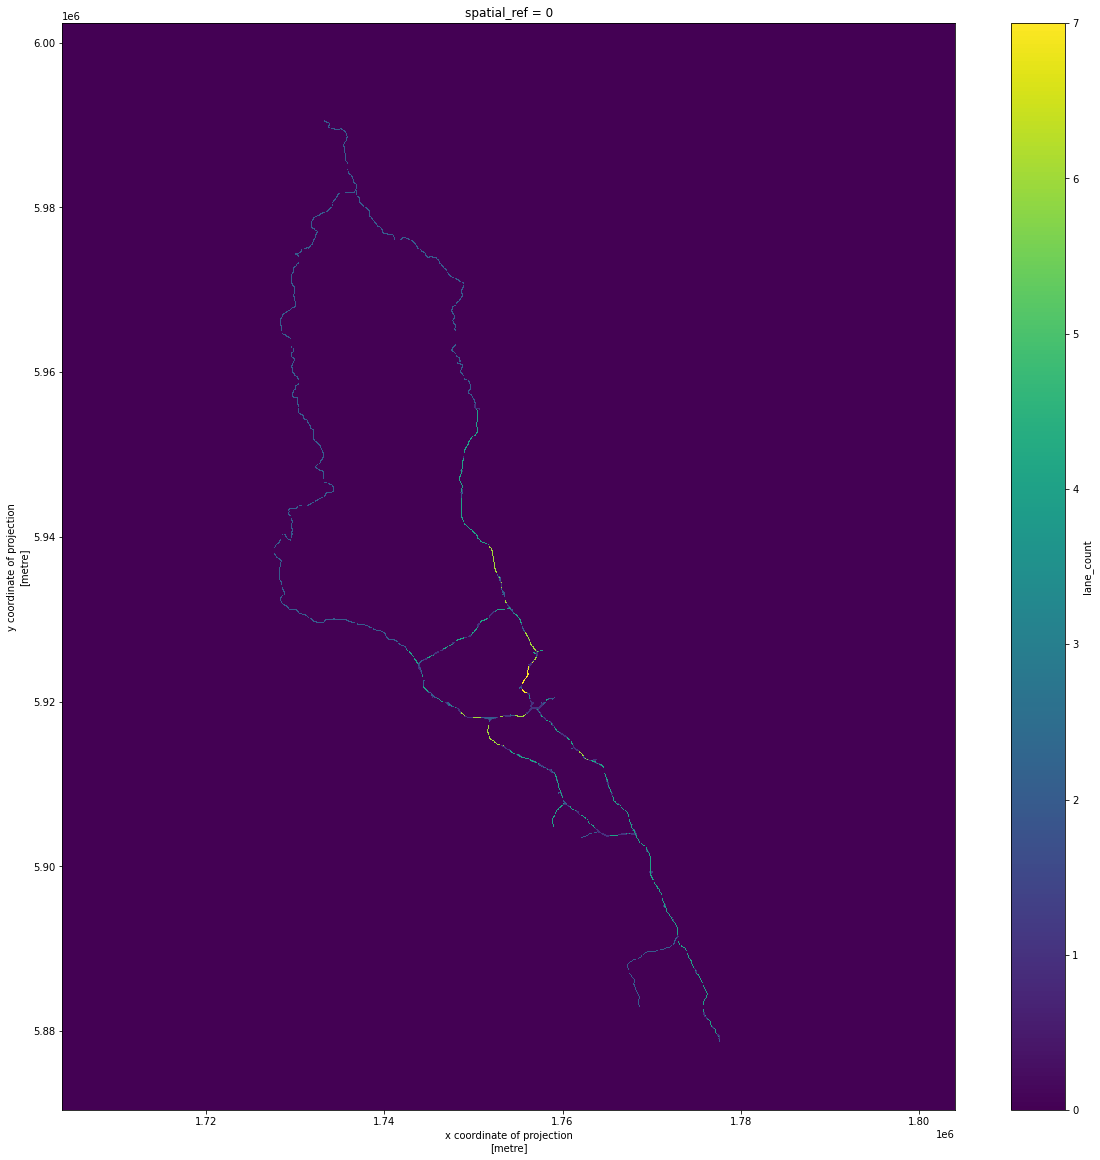

In [37]:
mway_cube.lane_count.plot()
outfile = "output/mway.tif"
if not os.path.isfile(outfile):
    mway_cube.lane_count.rio.to_raster(outfile, dtype=np.byte)

(1320, 1001)


Text(0.5, 1.0, 'Distance (m)')

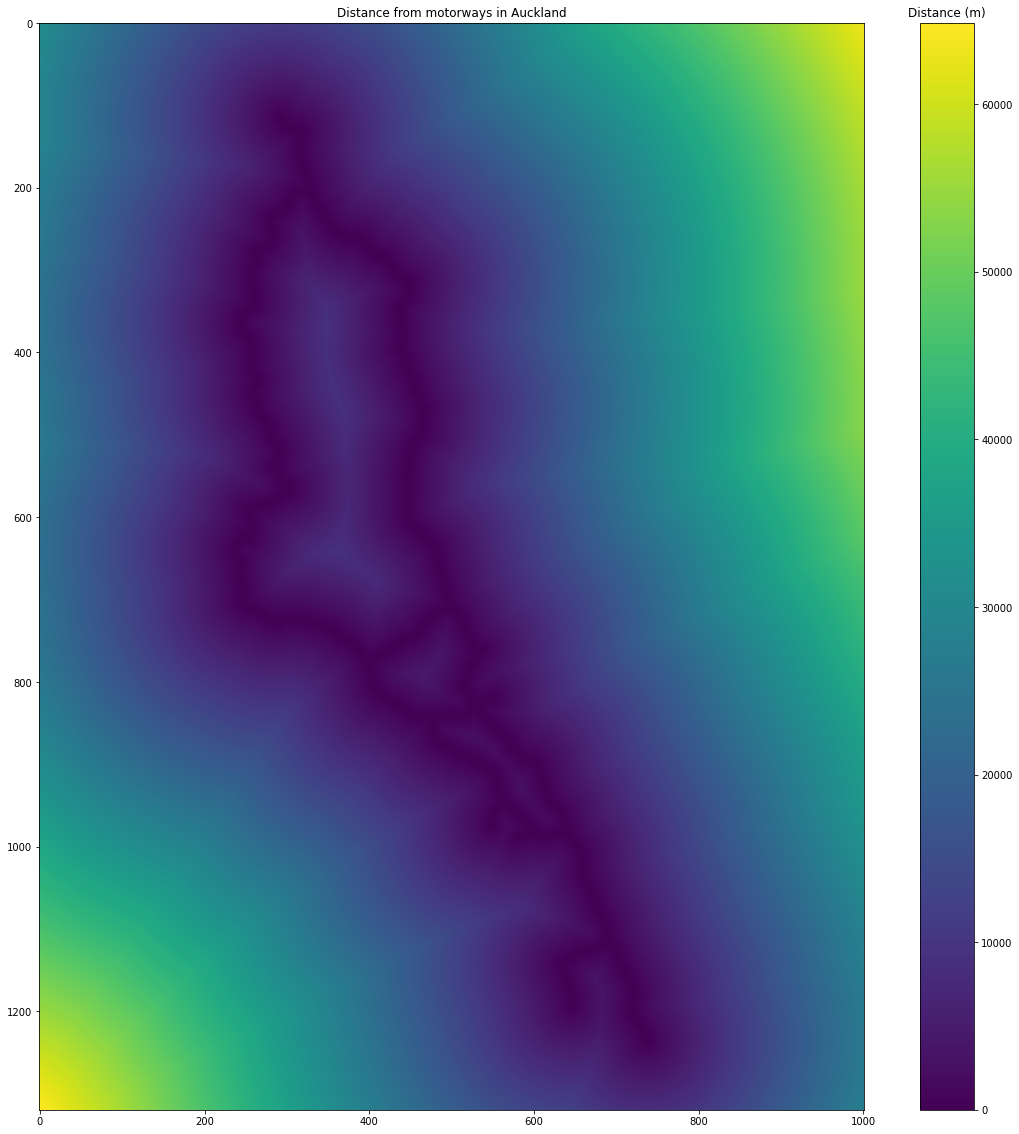

In [38]:
src_ds = gdal.Open("output/mway.tif")
srcband = src_ds.GetRasterBand(1)
dst_filename = "output/mway_dist.tif"
drv = gdal.GetDriverByName('GTiff')
dst_ds = drv.Create( dst_filename,
                     src_ds.RasterXSize, src_ds.RasterYSize, 1,
                     gdal.GetDataTypeByName('UInt16'))
dst_ds.SetGeoTransform( src_ds.GetGeoTransform() )
dst_ds.SetProjection( src_ds.GetProjectionRef() )
dstband = dst_ds.GetRasterBand(1)
prox = gdal.ComputeProximity(srcband,dstband,["DISTUNITS=GEO"]) # Encoded value is distance from motorway in meters
# Garbage collection of this variable flushes write
dst_ds = None
dst_ds = gdal.Open(dst_filename)
mway_dist = np.array(dst_ds.GetRasterBand(1).ReadAsArray())
print(mway_dist.shape)
plt.imshow(mway_dist)
plt.title("Distance from motorways in Auckland")
cb = plt.colorbar()
cb.ax.set_title("Distance (m)")

### Distance from CBD

(1320, 1001)
CPU times: user 460 ms, sys: 10 ms, total: 470 ms
Wall time: 468 ms


Text(0.5, 1.0, 'Distance (m)')

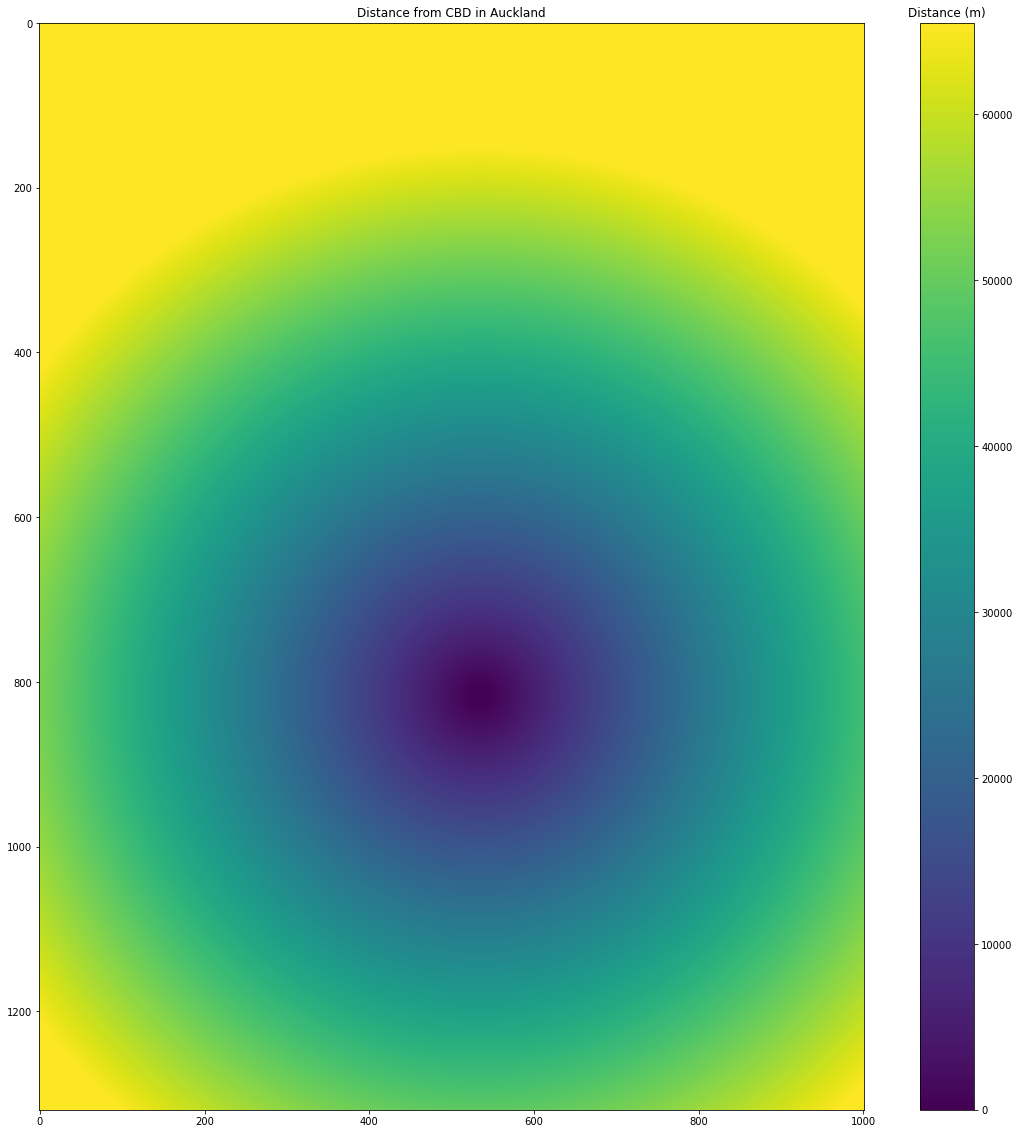

In [39]:
%%time
cbd = pop2018[pop2018.MB2020_V2_00 == "0433501"].copy()
cbd.geometry = cbd.geometry.buffer(1000)
cbd_cube = make_geocube(
    vector_data=cbd,
    like=geocube, # Ensures dimensions match
    fill=0
)
outfile = "output/cbd.tif"
if not os.path.isfile(outfile):
    cbd_cube.General_Electoral_Population.rio.to_raster(outfile, dtype=np.byte)
    
src_ds = gdal.Open("output/cbd.tif")
srcband = src_ds.GetRasterBand(1)
dst_filename = "output/cbd_dist.tif"
drv = gdal.GetDriverByName('GTiff')
dst_ds = drv.Create( dst_filename,
                     src_ds.RasterXSize, src_ds.RasterYSize, 1,
                     gdal.GetDataTypeByName('UInt16'))
dst_ds.SetGeoTransform( src_ds.GetGeoTransform() )
dst_ds.SetProjection( src_ds.GetProjectionRef() )
dstband = dst_ds.GetRasterBand(1)
prox = gdal.ComputeProximity(srcband,dstband,["DISTUNITS=GEO"]) # Encoded value is distance from motorway in meters
# Garbage collection of this variable flushes write
dst_ds = None
dst_ds = gdal.Open(dst_filename)
cbd_dist = np.array(dst_ds.GetRasterBand(1).ReadAsArray())
print(cbd_dist.shape)
plt.imshow(cbd_dist)
plt.title("Distance from CBD in Auckland")
cb = plt.colorbar()
cb.ax.set_title("Distance (m)")

# Slope

In [58]:
bounds = AKL.total_bounds.tolist()
bounds

[1703081.9789640256, 5870396.320936217, 1804839.668875325, 6002367.198185163]

In [59]:
zf = zipfile.ZipFile('input/lds-nz-8m-digital-elevation-model-2012-GTiff-auckland-region.zip')
tiles = [file for file in zf.namelist() if file.endswith(".tif")]
tiles

['EJ.tif',
 'DM.tif',
 'EL.tif',
 'DL.tif',
 'DJ.tif',
 'FK.tif',
 'DK.tif',
 'EK.tif',
 'FL.tif']

In [60]:
tile_datasets = [rasterio.open(f'zip://input/lds-nz-8m-digital-elevation-model-2012-GTiff-auckland-region.zip!{tile}') for tile in tiles]
DEM, transformation = rasterio.merge.merge(tile_datasets, bounds = bounds, res = (100,100), dtype=np.int16)

-32767 -18316.517014943143 697 (1, 1320, 1018)


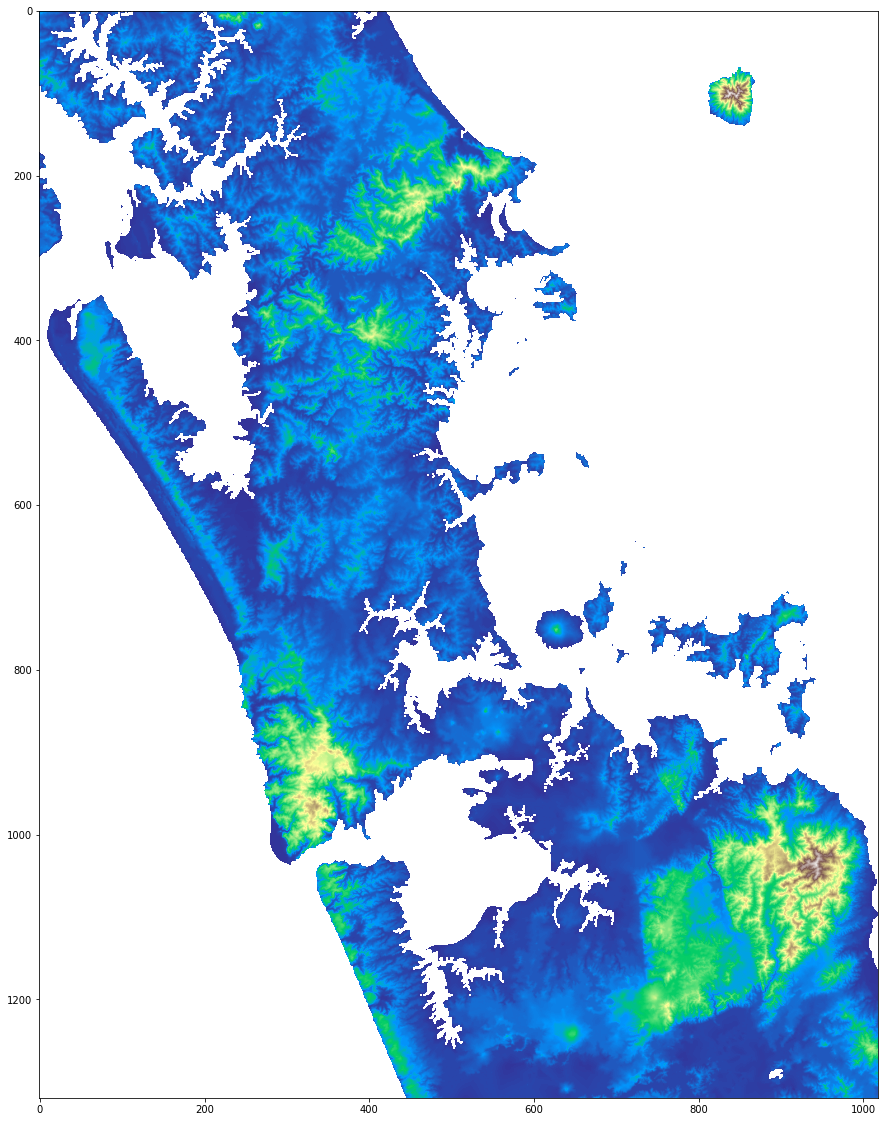

<AxesSubplot:>

In [61]:
print(np.nanmin(DEM), np.nanmean(DEM), np.nanmax(DEM), DEM.shape)
rasterio.plot.show(np.where(DEM>=0, DEM, np.nan), cmap='terrain')

In [62]:
transformation, width, height = rasterio.warp.aligned_target(cbd_dist.transform, cbd_dist.width, cbd_dist.height, cbd_dist.res)

In [64]:
meta = tile_datasets[0].meta
print(meta)
meta.update({
    "dtype": "int16",
    "height": height,
    "width": width,
    "transform": transformation
})
print(meta)
outfile = "output/slope.tif"
if not os.path.isfile(outfile):
    with rasterio.open(outfile, "w", **meta) as dest:
       dest.write(DEM)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 3028, 'height': 8192, 'count': 1, 'crs': CRS.from_epsg(2193), 'transform': Affine(8.0, 0.0, 1679712.0,
       0.0, -8.0, 5963776.0)}
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 1001, 'height': 1320, 'count': 1, 'crs': CRS.from_epsg(2193), 'transform': Affine(100.0, 0.0, 1703900.0,
       0.0, -100.0, 6002400.0)}


In [80]:
rasters = [rasterio.open(f"output/{f}") for f in os.listdir("output")]
params = set([(r.shape, r.res, r.crs, r.count, r.bounds) for r in rasters])
print(params)
# Assert all rasters have the same shape, pixel size, CRS, number of bands, and bounds
assert len(params) == 1

{((1320, 1001), (100.0, 100.0), CRS.from_epsg(2193), 1, BoundingBox(left=1703900.0, bottom=5870400.0, right=1804000.0, top=6002400.0))}


In [81]:
!ls -Ggh output

total 22M
-rw-r--r-- 1 1.3M Apr 16 14:44 cbd.tif
-rw-r--r-- 1 2.6M Apr 16 13:58 cbd_dist.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 land_use_1996.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 land_use_2001.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 land_use_2008.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 land_use_2012.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 land_use_2018.tif
-rw-r--r-- 1 1.3M Apr 16 09:50 mway.tif
-rw-r--r-- 1 2.6M Apr 16 13:58 mway_dist.tif
-rw-r--r-- 1 2.6M Apr 16 09:50 pop2013.tif
-rw-r--r-- 1 2.6M Apr 16 09:50 pop2018.tif
-rw-r--r-- 1 2.6M Apr 16 14:39 slope.tif
